# ODSC Webinar: OmniSci and RAPIDS
## An End-to-End GPU Data Science Workflow

May 30, 2019

## 1. Connecting to OmniSciDB (Open Source)
https://github.com/omnisci/omniscidb

In [1]:
#import pymapd to connect to OmniSci
#importing pandas is for convenience with the pd.read_sql method
import pymapd
import pandas as pd
from credentials import credentials

In [2]:
# Connect to OmniSciDB, get list of tables in database
conn = pymapd.connect(host="localhost", 
                      dbname=credentials["dbname"], 
                      user=credentials["user"], 
                      password=credentials["password"])

conn.get_tables()

['free_bike_status', 'station_status']

## 2. Simple query demonstrating data is streaming into OmniSciDB

In [4]:
import datetime
from datetime import timedelta

# Create start and end timestamps for substitution
now_ = datetime.datetime.now()
xminsago_ = datetime.datetime.now() - timedelta(minutes=5)

# Query counts number of records inserted in the last X number of minutes
query = f"""
SELECT 
date_trunc(minute, accessed_on) accessed_on,
COUNT(*) AS records
FROM free_bike_status 
WHERE accessed_on BETWEEN '{xminsago_}' AND '{now_}' 
GROUP BY 1
ORDER BY 1 DESC
"""

# OmniSci gets its speed two ways: high GPU bandwidth/core density & compiling queries with LLVM
# First run will be slower because query is compiled and/or data streamed to GPU
# Second run on will be fast because data already in GPU memory and query compiled, NOT because result is cached
%time df = pd.read_sql(query, conn)

CPU times: user 2.56 ms, sys: 0 ns, total: 2.56 ms
Wall time: 24 ms


In [5]:
df

,accessed_on,records
0,2019-05-30 15:11:00,12864
1,2019-05-30 15:10:00,14256
2,2019-05-30 15:09:00,14270
3,2019-05-30 15:08:00,14252
4,2019-05-30 15:07:00,14244


## 3. Using Ibis for a pandas-like API over billions of records

If you're more comfortable using pandas than SQL, you can use Ibis for a similar workflow.<br>
https://www.omnisci.com/blog/scaling-pandas-to-the-billions-with-ibis-and-mapd/

In [6]:
#ibis is alternate method for querying using pandas-like API
import ibis

In [7]:
#connection string similar to pymapd
ibiscon = ibis.mapd.connect(host="localhost", 
                            database=credentials["dbname"], 
                            user=credentials["user"], 
                            password=credentials["password"],
                            port=6274)

#can list tables in similar manner as well
ibiscon.list_tables()

['free_bike_status', 'station_status']

In [8]:
#create a table reference
#this doesn't bring the data local, Ibis is a lazy-execution engine
free_bike_status = ibiscon.table('free_bike_status')

In [59]:
#get number of bikes in seattle per minute
seattle_jumpbike_by_minute = (free_bike_status[['accessed_on', 'baseurl']]
                             .filter([free_bike_status.baseurl == "http://sea.jumpbikes.com/opendata"])
                             .group_by(["accessed_on"])
                             .aggregate(free_bike_status.baseurl.count().name("available_bikes"))
                             .sort_by([("accessed_on", False)])
                             )

#to see generated query
#print(ibiscon.compile(seattle_jumpbike_by_minute))

#to see Ibis diagram
#seattle_jumpbike_by_minute

In [60]:
#to force execution and return a result as a pandas dataframe
seattle_bikes = ibiscon.execute(seattle_jumpbike_by_minute)
type(seattle_bikes)

pandas.core.frame.DataFrame

## 4. Plot with Altair

Because the calculation was done on GPU, we can quickly return the result to pandas and plot with Altair. This is a CPU-transfer, but a small one relative to returning entire Seattle bike-level data, then using pandas, then using Altair

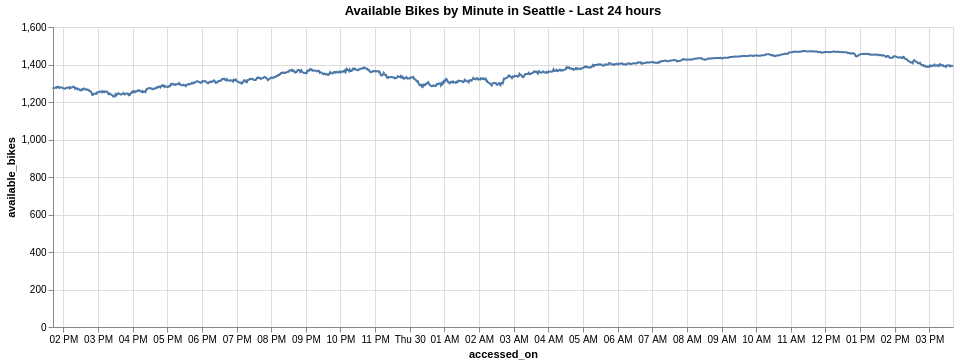

In [73]:
import altair as alt

(alt.Chart(seattle_bikes.head(24*60), width=900)
    .mark_line()
    .encode(x='accessed_on',y='available_bikes')
    .properties(title='Available Bikes by Minute in Seattle - Last 24 hours')
)

## 5. Returning results as a GPU dataframe

If you analysis doesn't stop at plotting, you can return the results in a cudf GPU DataFrame via pymapd

In [82]:
seattle_last_5_mins = f"""select 
                         extract(EPOCH from accessed_on) as epoch_seconds, 
                         name, 
                         lat, 
                         lon,
                         vehicle_type
                         from free_bike_status
                         where baseurl = 'http://sea.jumpbikes.com/opendata'
                         and accessed_on BETWEEN '{xminsago_}' AND '{now_}'
                         and is_reserved = false
                       """

In [83]:
seattle_gdf = conn.select_ipc_gpu(seattle_last_5_mins)

In [84]:
type(seattle_gdf)

cudf.dataframe.dataframe.DataFrame

In [86]:
print(seattle_gdf.head())

   epoch_seconds   name                 lat                  lon  vehicle_type
0     1559229000  09345   47.62139666666667           -122.29369          bike
1     1559229000  08721   47.65327833333333           -122.27696          bike
2     1559229000  10429  47.586353333333335  -122.31589333333334          bike
3     1559229000  09670           47.608155  -122.34030666666666          bike
4     1559229000  10065  47.699779920139406  -122.34350323677063          bike


## 6. Machine Learning with GPU DataFrames

Because GPUs are well-suited to do math operations, they are commonly used for predictive modeling and machine learning. To see how cudf DataFrames can
be used to predict electricity demand, see my other video from PyData NYC 2018, where I show how to calculate a linear model using the normal equation. <br>
https://www.youtube.com/watch?v=gQszQcFHcZc&t=

In [90]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/gQszQcFHcZc" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')